# Introduction

In this section, we are going to assess the capability of EXPERT on CRC detection. The data comes from *[REF]* (below). Detailed illustration of the results is avaliable in our papar (below).

[REF]

# Resources

|Resource|Description|
| - | - |
|`dataFiles`|data files used in this tutorial.|
|`experiments`|intermediate/temporary files generated by the program.|

# Reproducibility statement

- EXPERT supports reproducible optimization & inference.
- Rerunning the entire notebook should yield **completely consistent** results (compared to those reported in our paper).

[REF]

## Set random seed to get reproducible result

In [1]:
from numpy.random import seed
seed(2)
from tensorflow.random import set_seed
set_seed(2)

## Import libraries and functions

In [2]:
import os
import matplotlib
import numpy as np
import pandas as pd

from expert.src.utils import read_genus_abu, read_labels, load_otlg, zero_weight_unk, parse_otlg, get_dmax
from expert.src.preprocessing import *
from expert.src.model import *
from expert.CLI.CLI_utils import find_pkg_resource as find_expert_resource

from tensorflow.keras.layers import Dense, Dropout, AlphaDropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.initializers import HeUniform, GlorotUniform

## Select base model

In [9]:
metrics =[pd.read_csv('../Disease-diagnosis/experiments/exp_{}/EvalResult_{}/overall.csv'.format(i, 'Train'), index_col=0)[['ROC-AUC']].rename(columns=lambda x: x + '_' + str(i))
        for i in range(5)]
overall = pd.concat(metrics, axis=1)
#avg = overall.T.groupby(by=overall.columns.to_series().apply(lambda x: '-'.join(x.split('-')[0:2]) + '(' + x.split('-')[3] + ')')).mean().T
#avg = avg.reset_index()
overall.mean().idxmax()

'ROC-AUC_3'

## Construct ontology using mapper file of source samples

In [19]:
!awk -F ',' '{print $5}' dataFiles/CRC_samples_stages.csv | grep -v "Env" | sort | uniq  > microbiomes.txt
!expert construct -i microbiomes.txt -o ontology.pkl

root:CRC (stage 0)
root:CRC (stage I)
root:CRC (stage II)
root:CRC (stage III)
root:CRC (stage IV)
Reading microbiome structure...
Generating Ontology...
100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 41282.52it/s]
root
├── root:CRC (stage 0)
├── root:CRC (stage I)
├── root:CRC (stage II)
├── root:CRC (stage III)
└── root:CRC (stage IV)

Done


## Set hyper-parameters for training process

In [4]:
init = HeUniform(seed=2)
sig_init = GlorotUniform(seed=2)
phylogeny_path = find_expert_resource('resources/phylogeny.csv')
ontology = load_otlg('ontology.pkl')
phylogeny = pd.read_csv(phylogeny_path, index_col=0)
lrreducer = ReduceLROnPlateau(monitor='val_loss', patience=5, min_lr=1e-5, verbose=5, factor=0.1)
stopper = EarlyStopping(monitor='val_loss', patience=15, verbose=5, restore_best_weights=True)
callbacks = [lrreducer, stopper]
phylogeny = pd.read_csv(find_expert_resource('resources/phylogeny.csv'), index_col=0)
optimizer = Adam(lr=1e-4)
metrics = [BinaryAccuracy(name='acc'), AUC(name='AUC')]
loss = BinaryCrossentropy()
epochs = 2000
batch_size = 32
validation_split = 0.1

## Preprocess the data, using EXPERT's command-line API 

In [23]:
%%bash

for((i=0; i<5; i++)); do \
ls experiments/exp_$i/QueryCM.tsv.gz > tmp; expert convert -i tmp --in-cm -o experiments/exp_$i/QueryCM.h5; \
ls experiments/exp_$i/SourceCM.tsv.gz > tmp; expert convert -i tmp --in-cm -o experiments/exp_$i/SourceCM.h5; \
expert map --to-otlg -t ontology.pkl -i experiments/exp_$i/SourceMapper.csv.gz -o experiments/exp_$i/SourceLabels.h5; \
expert map --to-otlg -t ontology.pkl -i experiments/exp_$i/QueryMapper.csv.gz -o experiments/exp_$i/QueryLabels.h5; \
done
#rm tmp

Mapping sources to microbiome ontology...
The ontology contains 2 layers.
Saving labels for each ontology layer...
root       571
Unknown      0
dtype: int64
root:CRC (stage 0)       15
root:CRC (stage I)      177
root:CRC (stage II)     117
root:CRC (stage III)     84
root:CRC (stage IV)     178
Unknown                   0
dtype: int64
Mapping sources to microbiome ontology...
The ontology contains 2 layers.
Saving labels for each ontology layer...
root       64
Unknown     0
dtype: int64
root:CRC (stage 0)       1
root:CRC (stage I)      19
root:CRC (stage II)      9
root:CRC (stage III)     9
root:CRC (stage IV)     26
Unknown                  0
dtype: int64
Mapping sources to microbiome ontology...
The ontology contains 2 layers.
Saving labels for each ontology layer...
root       571
Unknown      0
dtype: int64
root:CRC (stage 0)       13
root:CRC (stage I)      180
root:CRC (stage II)     114
root:CRC (stage III)     80
root:CRC (stage IV)     184
Unknown                   0
dtyp

100%|██████████| 2/2 [00:00<00:00, 28.92it/s]


## Evaluate the model 

In [32]:
%%bash
for i in {0,1,2,3,4}; do
    mkdir running_$i;
    expert train -i experiments/exp_$i/SourceCM.h5 -t ontology.pkl -l experiments/exp_$i/SourceLabels.h5 -o experiments/exp_$i/TrainModel;
    expert search -i experiments/exp_$i/QueryCM.h5 -m experiments/exp_$i/TrainModel -o experiments/exp_$i/SearchResult_Train;
    expert evaluate -i experiments/exp_$i/SearchResult_Train -l experiments/exp_$i/QueryLabels.h5 -o experiments/exp_$i/EvalResult_Train -S 0;

    expert transfer -i experiments/exp_$i/SourceCM.h5 -t ontology.pkl -l experiments/exp_$i/SourceLabels.h5 -o experiments/exp_$i/AdaptModel_ft_HM \
            -m HumanModel/ --finetune --update-statistics;
    expert search -i experiments/exp_$i/QueryCM.h5 -m experiments/exp_$i/AdaptModel_ft_HM -o experiments/exp_$i/SearchResult_Adapt_ft_HM;
    expert evaluate -i experiments/exp_$i/SearchResult_Adapt_ft_HM -l experiments/exp_$i/QueryLabels.h5 -o experiments/exp_$i/EvalResult_Adapt_ft_HM -S 0;

    expert transfer -i experiments/exp_$i/SourceCM.h5 -t ontology.pkl -l experiments/exp_$i/SourceLabels.h5 -o experiments/exp_$i/AdaptModel_ft_DM \
            -m ../Disease-diagnosis/experiments/exp_3/TrainModel/ --finetune --update-statistics;
    expert search -i experiments/exp_$i/QueryCM.h5 -m experiments/exp_$i/AdaptModel_ft_DM -o experiments/exp_$i/SearchResult_Adapt_ft_DM;
    expert evaluate -i experiments/exp_$i/SearchResult_Adapt_ft_DM -l experiments/exp_$i/QueryLabels.h5 -o experiments/exp_$i/EvalResult_Adapt_ft_DM -S 0;
done

Reordering labels and samples...
Total matched samples: 571
N. NaN in input features: 0
           mean       std
0      0.000000  0.000000
1      0.000000  0.000000
2      0.000000  0.000000
3      0.015062  0.041284
4      0.015041  0.041268
...         ...       ...
18013  0.000061  0.000243
18014  0.000000  0.000000
18015  0.002382  0.011947
18016  0.002317  0.011715
18017  0.000000  0.000000

[18018 rows x 2 columns]
Pre-training using Adam with lr=1e-05...
Epoch 1/2
1/1 [==============================] - 0s 411ms/step - loss: 0.7021 - acc: 0.4877 - val_loss: 0.7029 - val_acc: 0.5069
Epoch 2/2
1/1 [==============================] - 0s 22ms/step - loss: 0.6914 - acc: 0.5099 - val_loss: 0.6967 - val_acc: 0.5448
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18018)]           0         
________________________________________________________

mkdir: cannot create directory ‘running_2’: File exists
2020-11-26 13:23:18.622388: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2020-11-26 13:23:18.629832: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2499960000 Hz
2020-11-26 13:23:18.631653: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x563da94111d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-11-26 13:23:18.631681: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-11-26 13:23:19.640297: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 144288144 exceeds 10% of free system memory.
2020-11-26 13:23:20.7306

## Visualize the evaluation result

In [5]:
matplotlib.rcParams['pdf.fonttype'] = 42

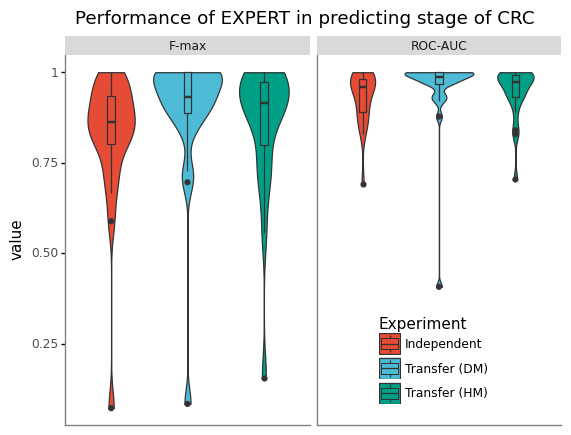

<ggplot: (8769686199556)>


/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 4.8 x 4.8 in image.
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: Figure_performance_across_models.pdf


In [9]:
metrics =[pd.read_csv('experiments/exp_{}/EvalResult_{}/overall.csv'.format(i, suffix), index_col=0).rename(columns=lambda x: '{}-exp_{}-{}'.format(x, i, suffix)).dropna()
        for i in range(5) for suffix in ['Train', 'Adapt_ft_DM', 'Adapt_ft_HM']]
overall = pd.concat(metrics, axis=1)
overall
overall = overall.reset_index().melt(id_vars=['index'], value_vars=overall.columns.tolist(), var_name='metric').dropna()
overall['Experiment'] = overall['metric'].str.split('-').apply(lambda x: '{}'.format( x[3])).map({'Adapt_ft_DM': 'Transfer (DM)', 'Adapt_ft_HM': 'Transfer (HM)', 'Train': 'Independent'})
overall['Metric'] = overall['metric'].str.split('-').apply(lambda x: '{}-{}'.format(x[0], x[1]))

from plotnine import *
plot = (ggplot(overall, aes(x='Experiment', y='value', fill='Experiment'))
         + geom_violin()
         + geom_boxplot(width=0.1)
         + scale_fill_manual(['#E64B35FF','#4DBBD5FF','#00A087FF','#3C5488FF','#F39B7FFF','#8491B4FF','#91D1C2FF'])
         + theme(axis_title_x=element_blank(), axis_text_x=element_blank(), legend_position = (0.70, 0.25))
         + theme(panel_grid_major = element_blank(), panel_grid_minor = element_blank(), panel_background = element_blank(), axis_ticks_major_x=element_blank(),
                 axis_line_x = element_line(color="gray", size = 1), axis_line_y = element_line(color="gray", size = 1))
         + xlab('Experiment')
         + facet_wrap('Metric')
         + ggtitle('Performance of EXPERT in predicting stage of CRC')
       )
print(plot)
plot.save('Figure_performance_across_models.pdf', dpi=120, width=4.8, height=4.8)

## Plot the data distribution

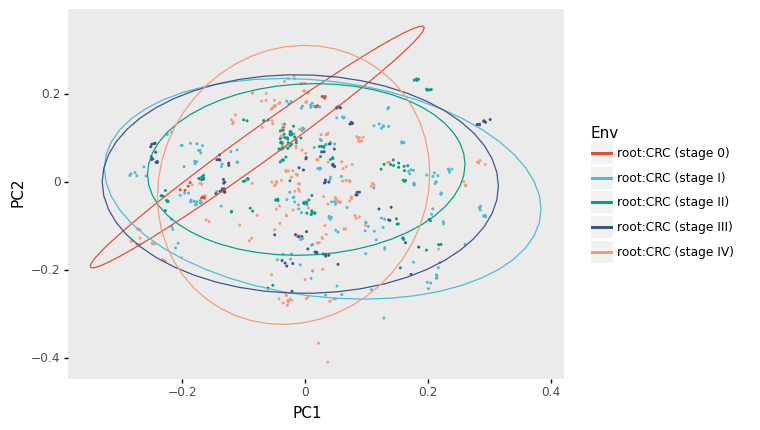

<ggplot: (8737347690006)>


In [177]:
X = pd.read_csv('dataFiles/species_abundance.csv', index_col=0).T
Y = pd.read_csv('dataFiles/CRC_samples_stages.csv').set_index('SampleID')

pcs = pd.DataFrame(pcoa(distances, number_of_dimensions=2).samples.values.tolist(), index=X.index, columns=['PC1', 'PC2'])
pcs = pd.concat([pcs, Y], axis=1)
plot = (ggplot(pcs, aes(x='PC1', y='PC2', color='Env'))
        + geom_point(size=0.2)
        + scale_color_manual(['#E64B35FF','#4DBBD5FF','#00A087FF','#3C5488FF','#F39B7FFF','#8491B4FF','#91D1C2FF'])
        + theme(panel_grid_major = element_blank(), panel_grid_minor = element_blank())
        + stat_ellipse()
        + xlab('PC1')
        + ylab('PC2')
       )
print(plot)

In [8]:
metrics =[pd.read_csv('experiments/exp_{}/EvalResult_{}/overall.csv'.format(i, 'Adapt_ft_DM'), index_col=0).rename(columns=lambda x: '{}-exp_{}-{}'.format(x, i, 'Adapt_ft_DM')).dropna()
        for i in range(5)]
overall = pd.concat(metrics, axis=1)
overall
overall = overall.reset_index().melt(id_vars=['index'], value_vars=overall.columns.tolist(), var_name='metric').dropna()
overall['Experiment'] = overall['metric'].str.split('-').apply(lambda x: '{}'.format( x[3])).map({'Adapt_ft_DM': 'Transfer (DM)', 'Adapt_ft_HM': 'Transfer (HM)', 'Train': 'Independent'})
overall['Metric'] = overall['metric'].str.split('-').apply(lambda x: '{}-{}'.format(x[0], x[1]))
overall = overall[overall.Metric == 'ROC-AUC'].groupby(by='index', as_index=False).mean().round(4)
overall['index'] = overall['index'].apply(lambda x: x.split(' ')[2].rstrip(')'))
overall['ROC-AUC'] = overall['value']
overall['Stage'] = overall['index']

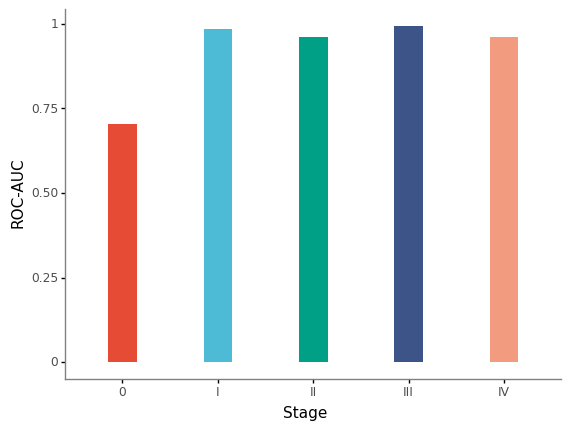

<ggplot: (8732487318995)>


/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 2.4 x 4.8 in image.
/home/chonghui/envs/miniconda3/envs/expert/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: CRC_stage_performance.pdf


In [9]:
from plotnine import *
plot = (ggplot(overall, aes(x='Stage', y='ROC-AUC', fill='Stage'))
         + geom_bar(stat='identity', width=0.3, show_legend = False)
         + scale_fill_manual(['#E64B35FF','#4DBBD5FF','#00A087FF','#3C5488FF','#F39B7FFF','#8491B4FF','#91D1C2FF'])
         + theme(panel_grid_major = element_blank(), panel_grid_minor = element_blank(), panel_background = element_blank(),
                 axis_line_x = element_line(color="gray", size = 1), axis_line_y = element_line(color="gray", size = 1))
       )
print(plot)
plot.save('CRC_stage_performance.pdf', dpi=120, width=2.4, height=4.8)

In [174]:
pd.read_csv('dataFiles/species_abundance.csv', index_col=0).to_csv('dataFiles/species_abundance.tsv', sep='\t')
!ls dataFiles/species_abundance.tsv > tmp
!expert convert -i tmp -o CRC_cm.h5 --in-cm
!for i in {0,1,2,3,4}; do expert search -i CRC_cm.h5 -o CRC_contribution_$i -m ../Disease-diagnosis/experiments/exp_$i/TrainModel; done

running...
Reading and concatenating data, this could be slow if you have huge amount of data
db file: /home/chonghui/.etetoolkit/taxa.sqlite
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.45it/s]
        ERR475482   ERR475493   ERR475500  ...   ERR481063   ERR481064   ERR481065
count  854.000000  854.000000  854.000000  ...  854.000000  854.000000  854.000000
mean     0.188848    0.155293    0.091492  ...    0.221712    0.225143    0.222403
std      2.274977    1.508092    1.018507  ...    4.716516    4.774864    4.758246
min      0.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
50%      0.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
max     47.130700   37.035000   24.845200  ...  135.370960  137.099840  136.803670

[6 rows x 635 columns]
Initializing in-memory taxonomy database for ultra-fast querying.
db file: /home/chonghui/.etetoolkit/taxa.sqlite
There will be 0/854 entries droped cause they are not in N

In [4]:
pd.read_csv('dataFiles/CRC_samples_stages.csv').disease_stage.value_counts()

IV     204
I      196
II     126
III     93
0       16
Name: disease_stage, dtype: int64